In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.optim import lr_scheduler

from open_clip import ClipLoss

In [29]:
with open('/home/docker_current/py_files/MLCLIP_exp/image_feat_array.npy', 'rb') as f:
    image_feat_array = np.load(f)

with open('/home/docker_current/py_files/MLCLIP_exp/text_feat_array.npy', 'rb') as f:
    text_feat_array = np.load(f)

X_train, X_test, y_train, y_test = train_test_split(text_feat_array, image_feat_array, 
                                                        test_size=0.25, random_state=42)

In [30]:
from torch.utils.data import TensorDataset, DataLoader

X_train_t = torch.FloatTensor(X_train) 
y_train_t = torch.FloatTensor(y_train) 
X_val_t = torch.FloatTensor(X_test) 
y_val_t = torch.FloatTensor(y_test) 

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=64)
val_dataloader = DataLoader(val_dataset, batch_size=64)

loaders = {"train": train_dataloader, "valid": val_dataloader}

In [31]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(768, 1380)
        self.fc2 = nn.Linear(1380, 768)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(768, 1380)
        self.fc2 = nn.Linear(1380, 768)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class MetaCLIP(nn.Module):
    def __init__(self):
        super().__init__()
        self.encode_image = ImageEncoder()
        self.encode_text = TextEncoder()
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

    def forward(self, image, text):
        #open_clip realization
        image_features = self.encode_image(image)
        image_features = F.normalize(image_features, dim=-1)

        text_features = self.encode_text(text)
        text_features = F.normalize(text_features, dim=-1)

        return image_features, text_features, self.logit_scale.exp()

In [32]:
import torch
from contextlib import suppress

# amp_bfloat16 is more stable than amp float16 for clip training
def get_autocast(precision):
    if precision == 'amp':
        return torch.cuda.amp.autocast
    elif precision == 'amp_bfloat16':
        return lambda: torch.cuda.amp.autocast(dtype=torch.bfloat16)
    else:
        return suppress

def is_global_master(args):
    return args.rank == 0

def is_local_master(args):
    return args.local_rank == 0

def is_master(args, local=False):
    return is_local_master(args) if local else is_global_master(args)

In [16]:
import numpy as np

def assign_learning_rate(optimizer, new_lr):
    for param_group in optimizer.param_groups:
        param_group["lr"] = new_lr

def _warmup_lr(base_lr, warmup_length, step):
    return base_lr * (step + 1) / warmup_length

def cosine_lr(optimizer, base_lr, warmup_length, steps):
    def _lr_adjuster(step):
        if step < warmup_length:
            lr = _warmup_lr(base_lr, warmup_length, step)
        else:
            e = step - warmup_length
            es = steps - warmup_length
            lr = 0.5 * (1 + np.cos(np.pi * e / es)) * base_lr
        assign_learning_rate(optimizer, lr)
        return lr
    return _lr_adjuster

In [17]:
from torch.cuda.amp import GradScaler
from torch import optim

class Args:
    device = 'cuda:0'
    precision = 'amp'
    local_loss = False
    gather_with_grad = False
    rank = 0
    world_size = 1
    horovod = False
    norm_gradient_clip = None
    batch_size = 64
    wandb = False
    val_frequency = 5
    save_logs = False
    epochs = 300
    lr = 0.2e-4

class SampleData():
    def __init__(self, dataset, batch_size):
        self.dataloader = DataLoader(dataset, batch_size=64)
        self.dataloader.num_samples = len(dataset)
        self.dataloader.num_batches = len(self.dataloader)

args = Args()

data = {}
data['train'] = SampleData(train_dataset, args.batch_size)
data['val'] = SampleData(val_dataset, args.batch_size)

model = MetaCLIP()
model.to(args.device)

optimizer = optim.AdamW(model.parameters(), lr=args.lr)
scaler = GradScaler() if args.precision == "amp" else None

total_steps = data["train"].dataloader.num_batches * args.epochs
scheduler = cosine_lr(optimizer, args.lr, 15, total_steps)

writer = None

In [18]:
model

MetaCLIP(
  (encode_image): ImageEncoder(
    (fc1): Linear(in_features=768, out_features=1380, bias=True)
    (fc2): Linear(in_features=1380, out_features=768, bias=True)
  )
  (encode_text): TextEncoder(
    (fc1): Linear(in_features=768, out_features=1380, bias=True)
    (fc2): Linear(in_features=1380, out_features=768, bias=True)
  )
)

In [19]:
import json
import logging
import math
import os
import time

import numpy as np
import torch
import torch.nn.functional as F

try:
    import wandb
except ImportError:
    wandb = None

from open_clip import ClipLoss

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def unwrap_model(model):
    if hasattr(model, 'module'):
        return model.module
    else:
        return model


def train_one_epoch(model, data, epoch, optimizer, scaler, scheduler, args, tb_writer=None):
    device = torch.device(args.device)
    autocast = get_autocast(args.precision)

    model.train()
    loss = ClipLoss(
        local_loss=args.local_loss,
        gather_with_grad=args.gather_with_grad,
        cache_labels=True,
        rank=args.rank,
        world_size=args.world_size,
        use_horovod=args.horovod)

    # data['train'].set_epoch(epoch)  # set epoch in process safe manner via sampler or shared_epoch
    dataloader = data['train'].dataloader
    # dataloader = data['train']

    num_batches_per_epoch = dataloader.num_batches
    sample_digits = math.ceil(math.log(dataloader.num_samples + 1, 10))

    loss_m = AverageMeter()
    batch_time_m = AverageMeter()
    data_time_m = AverageMeter()
    end = time.time()
    for i, batch in enumerate(dataloader):
        step = num_batches_per_epoch * epoch + i
        scheduler(step)

        images, texts = batch
        images = images.to(device=device, non_blocking=True)
        texts = texts.to(device=device, non_blocking=True)

        data_time_m.update(time.time() - end)
        optimizer.zero_grad()

        with autocast():
            image_features, text_features, logit_scale = model(images, texts)
            total_loss = loss(image_features, text_features, logit_scale)

        if scaler is not None:
            scaler.scale(total_loss).backward()
            if args.horovod:
                optimizer.synchronize()
                scaler.unscale_(optimizer)
                if args.norm_gradient_clip is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.norm_gradient_clip, norm_type=2.0)
                with optimizer.skip_synchronize():
                    scaler.step(optimizer)
            else:
                if args.norm_gradient_clip is not None:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.norm_gradient_clip, norm_type=2.0)
                scaler.step(optimizer)
            scaler.update()
        else:
            total_loss.backward()
            if args.norm_gradient_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), args.norm_gradient_clip, norm_type=2.0)
            optimizer.step()

        # Note: we clamp to 4.6052 = ln(100), as in the original paper.
        with torch.no_grad():
            unwrap_model(model).logit_scale.clamp_(0, math.log(100))

        batch_time_m.update(time.time() - end)
        end = time.time()
        batch_count = i + 1

        # print(total_loss)
        
        if is_master(args) and (i % 100 == 0 or batch_count == num_batches_per_epoch):
            batch_size = len(images)
            num_samples = batch_count * batch_size * args.world_size
            samples_per_epoch = dataloader.num_samples
            percent_complete = 100.0 * batch_count / num_batches_per_epoch

            # NOTE loss is coarsely sampled, just master node and per log update
            loss_m.update(total_loss.item(), batch_size)
            logit_scale_scalar = logit_scale.item()
            logging.info(
                f"Train Epoch: {epoch} [{num_samples:>{sample_digits}}/{samples_per_epoch} ({percent_complete:.0f}%)] "
                f"Loss: {loss_m.val:#.5g} ({loss_m.avg:#.4g}) "
                f"Data (t): {data_time_m.avg:.3f} "
                f"Batch (t): {batch_time_m.avg:.3f}, {args.batch_size*args.world_size / batch_time_m.val:#g}/s "
                f"LR: {optimizer.param_groups[0]['lr']:5f} "
                f"Logit Scale: {logit_scale_scalar:.3f}"
            )

            # Save train loss / etc. Using non avg meter values as loggers have their own smoothing
            log_data = {
                "loss": loss_m.val,
                "data_time": data_time_m.val,
                "batch_time": batch_time_m.val,
                "samples_per_scond": args.batch_size*args.world_size / batch_time_m.val,
                "scale":  logit_scale_scalar,
                "lr": optimizer.param_groups[0]["lr"]
            }
            for name, val in log_data.items():
                name = "train/" + name
                if tb_writer is not None:
                    tb_writer.add_scalar(name, val, step)
                if args.wandb:
                    assert wandb is not None, 'Please install wandb.'
                    wandb.log({name: val, 'step': step})

            # resetting batch / data time meters per log window
            batch_time_m.reset()
            data_time_m.reset()
    # end for


def evaluate(model, data, epoch, args, tb_writer=None):
    metrics = {}
    # if not is_master(args):
    #     return metrics
    device = torch.device(args.device)
    model.eval()

    # zero_shot_metrics = zero_shot_eval(model, data, epoch, args)
    # metrics.update(zero_shot_metrics)

    autocast = get_autocast(args.precision)

    
    # if 'val' in data and (args.val_frequency and ((epoch % args.val_frequency) == 0 or epoch == args.epochs)):
    dataloader = data['val'].dataloader
    num_samples = 0
    samples_per_val = dataloader.num_samples

    # FIXME this does not scale past small eval datasets
    # all_image_features @ all_text_features will blow up memory and compute very quickly
    cumulative_loss = 0.0
    all_image_features, all_text_features = [], []
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            images, texts = batch
            images = images.to(device=device, non_blocking=True)
            texts = texts.to(device=device, non_blocking=True)

            with autocast():
                image_features, text_features, logit_scale = model(images, texts)
                # features are accumulated in CPU tensors, otherwise GPU memory exhausted quickly
                # however, system RAM is easily exceeded and compute time becomes problematic
                all_image_features.append(image_features.cpu())
                all_text_features.append(text_features.cpu())
                logit_scale = logit_scale.mean()
                logits_per_image = logit_scale * image_features @ text_features.t()
                logits_per_text = logits_per_image.t()

                batch_size = images.shape[0]
                labels = torch.arange(batch_size, device=device).long()
                total_loss = (
                    F.cross_entropy(logits_per_image, labels) +
                    F.cross_entropy(logits_per_text, labels)
                ) / 2

            cumulative_loss += total_loss * batch_size
            num_samples += batch_size
            if is_master(args) and (i % 100) == 0:
                logging.info(
                    f"Eval Epoch: {epoch} [{num_samples} / {samples_per_val}]\t"
                    f"Loss: {cumulative_loss / num_samples:.6f}\t")

        val_metrics = get_metrics(
            image_features=torch.cat(all_image_features),
            text_features=torch.cat(all_text_features),
            logit_scale=logit_scale.cpu(),
        )
        loss = cumulative_loss / num_samples
        metrics.update(
            {**val_metrics, "val_loss": loss.item(), "epoch": epoch, "num_samples": num_samples}
        )
        
        # print(loss)

    # if not metrics:
    #     return metrics

    logging.info(
        f"Eval Epoch: {epoch} "
        + "\t".join([f"{k}: {round(v, 4):.4f}" for k, v in metrics.items()])
    )

    if args.save_logs:
        for name, val in metrics.items():
            if tb_writer is not None:
                tb_writer.add_scalar(f"val/{name}", val, epoch)

        with open(os.path.join(args.checkpoint_path, "results.jsonl"), "a+") as f:
            f.write(json.dumps(metrics))
            f.write("\n")

    if args.wandb:
        assert wandb is not None, 'Please install wandb.'
        for name, val in metrics.items():
            wandb.log({f"val/{name}": val, 'epoch': epoch})

    return loss


def get_metrics(image_features, text_features, logit_scale):
    metrics = {}
    logits_per_image = (logit_scale * image_features @ text_features.t()).detach().cpu()
    logits_per_text = logits_per_image.t().detach().cpu()

    logits = {"image_to_text": logits_per_image, "text_to_image": logits_per_text}
    ground_truth = torch.arange(len(text_features)).view(-1, 1)

    for name, logit in logits.items():
        ranking = torch.argsort(logit, descending=True)
        preds = torch.where(ranking == ground_truth)[1]
        preds = preds.detach().cpu().numpy()
        metrics[f"{name}_mean_rank"] = preds.mean() + 1
        metrics[f"{name}_median_rank"] = np.floor(np.median(preds)) + 1
        for k in [1, 5, 10]:
            metrics[f"{name}_R@{k}"] = np.mean(preds < k)

    return metrics

In [20]:
# from tqdm.notebook import tqdm

start_epoch = 0
completed_epoch = 0

best_val_loss = 1e6
val_losses = []

for epoch in range(start_epoch, args.epochs):
    # if is_master(args):
    logging.info(f'Start epoch {epoch}')

    train_one_epoch(model, data, epoch, optimizer, scaler, scheduler, args, writer)
    val_loss = evaluate(model, data, completed_epoch, args, writer)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'metaclip_v3.pth')
        print("model loaded with best loss ", best_val_loss)
    
    completed_epoch = epoch + 1

model loaded with best loss  tensor(3.1427, device='cuda:0')
model loaded with best loss  tensor(2.3618, device='cuda:0')
model loaded with best loss  tensor(1.8982, device='cuda:0')
model loaded with best loss  tensor(1.6564, device='cuda:0')
model loaded with best loss  tensor(1.5130, device='cuda:0')
model loaded with best loss  tensor(1.4113, device='cuda:0')
model loaded with best loss  tensor(1.3337, device='cuda:0')
model loaded with best loss  tensor(1.2719, device='cuda:0')
model loaded with best loss  tensor(1.2214, device='cuda:0')
model loaded with best loss  tensor(1.1800, device='cuda:0')
model loaded with best loss  tensor(1.1452, device='cuda:0')
model loaded with best loss  tensor(1.1165, device='cuda:0')
model loaded with best loss  tensor(1.0923, device='cuda:0')
model loaded with best loss  tensor(1.0721, device='cuda:0')
model loaded with best loss  tensor(1.0552, device='cuda:0')
model loaded with best loss  tensor(1.0409, device='cuda:0')
model loaded with best l

0.881014883518219


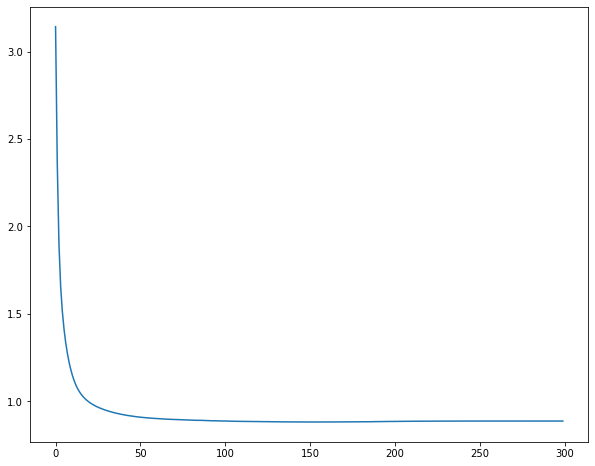

In [21]:
import matplotlib.pyplot as plt
val_losses = [i.tolist() for i in val_losses]
plt.figure(figsize=(10, 8))
plt.plot(val_losses)
print(min(val_losses))

In [22]:
val_losses[np.argmin(np.array(val_losses))]

0.881014883518219